In [1]:
import numpy as np
import os
from scipy.io.wavfile import write

def generate_noisy_machine_signal(base_freq, duration=10, sr=16000, noise_level=0.05, anomaly=False):
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)

    drift = np.random.uniform(-2, 2)
    freq = base_freq + drift
    base = 0.5 * np.sin(2 * np.pi * freq * t)

    noise = np.random.normal(0, noise_level, base.shape)
    signal = base + noise

    if anomaly:
        for _ in range(5):
            idx = np.random.randint(0, len(signal) - sr//10)
            burst_freq = np.random.uniform(2000, 3000)
            burst = 0.5 * np.sin(2 * np.pi * burst_freq * t[:sr//10])
            signal[idx:idx+sr//10] += burst

    signal = np.clip(signal, -1.0, 1.0)
    return (signal * 32767).astype(np.int16)

# Paths
base_path = "ToyADMOS"
machines = ["ToyCar", "ToyTrain", "ToyConveyor"]
labels = ["normal", "anomaly"]

# Files per machine to reach ~200 total
files_per_class = {
    "ToyCar": 34,
    "ToyTrain": 33,
    "ToyConveyor": 33
}

# Create dataset
for machine in machines:
    for label in labels:
        path = os.path.join(base_path, machine, label)
        os.makedirs(path, exist_ok=True)

        for i in range(files_per_class[machine]):
            is_anomaly = (label == "anomaly")
            base_freq = {"ToyCar": 120, "ToyTrain": 160, "ToyConveyor": 200}[machine]
            audio = generate_noisy_machine_signal(base_freq, anomaly=is_anomaly)
            write(os.path.join(path, f"{label}_{i}.wav"), 16000, audio)

print(f"✅ Done! Generated ~200 synthetic audio files in '{base_path}'.")

✅ Done! Generated ~200 synthetic audio files in 'ToyADMOS'.


TASK 1


# Convert .wav to melspectograms

In [2]:
import librosa
import librosa.display
import matplotlib.pyplot as plt

def create_and_save_highres_spectrogram(wav_path, save_path, fig_size=(5,5), dpi=150):
    y, sr = librosa.load(wav_path, sr=16000)
    S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
    log_S = librosa.power_to_db(S, ref=np.max)

    plt.figure(figsize=fig_size)
    librosa.display.specshow(log_S, sr=sr, hop_length=512)
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(save_path, bbox_inches='tight', pad_inches=0, dpi=dpi)
    plt.close()

# Spectrogram base folder
spec_base = "ToyADMOS_Spectrograms"
for machine in machines:
    for label in labels:
        wav_folder = os.path.join(base_path, machine, label)
        spec_folder = os.path.join(spec_base, machine, label)
        os.makedirs(spec_folder, exist_ok=True)

        for file in os.listdir(wav_folder):
            if file.endswith(".wav"):
                wav_path = os.path.join(wav_folder, file)
                save_path = os.path.join(spec_folder, file.replace(".wav", ".png"))
                create_and_save_highres_spectrogram(wav_path, save_path)

print(f"✅ Done! High-res spectrograms saved to '{spec_base}'.")

✅ Done! High-res spectrograms saved to 'ToyADMOS_Spectrograms'.


Ensuring dtaa split. it will be 70% training, 15% validation and 15% testing

In [3]:
import random
import shutil
import os

# Base paths
source_base = "ToyADMOS_Spectrograms"
target_base = "data_balanced"

# Re-create destination folders
for split in ['train', 'val', 'test']:
    for label in ['normal', 'anomaly']:
        os.makedirs(os.path.join(target_base, split, label), exist_ok=True)

# Collect all files with machine info
all_files = []  # (filepath, label, machine)

machines = ["ToyCar", "ToyTrain", "ToyConveyor"]
labels = ["normal", "anomaly"]

for machine in machines:
    for label in labels:
        src_folder = os.path.join(source_base, machine, label)
        for file in os.listdir(src_folder):
            full_path = os.path.join(src_folder, file)
            all_files.append((full_path, label, machine))  # save machine info too!

# Shuffle all files
random.shuffle(all_files)

# Split per class
normal_files = [f for f in all_files if f[1] == "normal"]
anomaly_files = [f for f in all_files if f[1] == "anomaly"]

# Function to split and copy, preserving machine info
def split_and_copy(files, label):
    n_total = len(files)
    n_train = int(0.7 * n_total)
    n_val = int(0.15 * n_total)
    n_test = n_total - n_train - n_val

    for idx, (src_path, lbl, machine) in enumerate(files[:n_train]):
        filename = f"{machine}_{os.path.basename(src_path)}"
        shutil.copy(src_path, os.path.join(target_base, 'train', label, filename))

    for idx, (src_path, lbl, machine) in enumerate(files[n_train:n_train+n_val]):
        filename = f"{machine}_{os.path.basename(src_path)}"
        shutil.copy(src_path, os.path.join(target_base, 'val', label, filename))

    for idx, (src_path, lbl, machine) in enumerate(files[n_train+n_val:]):
        filename = f"{machine}_{os.path.basename(src_path)}"
        shutil.copy(src_path, os.path.join(target_base, 'test', label, filename))

# Now split and copy both normal and anomaly files
split_and_copy(normal_files, "normal")
split_and_copy(anomaly_files, "anomaly")

print(f"✅ Done! Random, balanced split completed with machine name preserved in filenames.")

✅ Done! Random, balanced split completed with machine name preserved in filenames.


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    'data_balanced/train',
    target_size=(224, 224),   # 🔥 Updated size
    batch_size=8,
    class_mode='binary'
)

val_generator = train_datagen.flow_from_directory(
    'data_balanced/val',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    'data_balanced/test',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 251 images belonging to 2 classes.
Found 122 images belonging to 2 classes.
Found 123 images belonging to 2 classes.


In [5]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

base_model = VGG16(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False

model = Sequential([
    base_model,
    Flatten(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


32/32 ━━━━━━━━━━━━━━━━━━━━ 198s 6s/step - accuracy: 0.6557 - loss: 0.5933 - val_accuracy: 1.0000 - val_loss: 0.1181
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 194s 6s/step - accuracy: 0.9924 - loss: 0.1222 - val_accuracy: 1.0000 - val_loss: 0.0203
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 228s 7s/step - accuracy: 1.0000 - loss: 0.0289 - val_accuracy: 1.0000 - val_loss: 0.0077
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - accuracy: 1.0000 - loss: 0.0147 - val_accuracy: 1.0000 - val_loss: 0.0052
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 213s 7s/step - accuracy: 1.0000 - loss: 0.0159 - val_accuracy: 1.0000 - val_loss: 0.0036
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - accuracy: 1.0000 - loss: 0.0088 - val_accuracy: 1.0000 - val_loss: 0.0028
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 195s 6s/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 1.0000 - val_loss: 0.0023
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 214s 7s/step - accuracy: 1.0000 - loss: 0.0051 - val_accuracy: 1.0000 - val_loss: 0.

The above prompt took 35 minutes to execute

The commant below generates the F1 scores and Accuracy Reports!

In [6]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, accuracy_score

# Predict all test data
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Get filepaths
filepaths = np.array(test_generator.filepaths)

# Machine types
machines = ["ToyCar", "ToyTrain", "ToyConveyor"]

print("🔎 Metrics Broken Down by Machine Type:\n")

for machine in machines:
    # Find indices belonging to this machine
    machine_idx = [i for i, path in enumerate(filepaths) if machine in path]

    # Extract true and predicted labels for this machine
    y_true_machine = y_true[machine_idx]
    y_pred_machine = y_pred[machine_idx]

    # 🔥 Fix: Skip if no samples
    if len(y_true_machine) == 0:
        print(f"⚠️ Skipping {machine}: No samples in test set.\n" + "-"*50)
        continue

    # Make sure they're arrays
    y_true_machine = np.array(y_true_machine).flatten()
    y_pred_machine = np.array(y_pred_machine).flatten()

    # Calculate metrics
    acc = accuracy_score(y_true_machine, y_pred_machine)
    f1 = f1_score(y_true_machine, y_pred_machine, zero_division=0)

    print(f"📁 {machine}:")
    print(f"   - Accuracy: {acc:.4f}")
    print(f"   - F1 Score: {f1:.4f}")
    print(f"   - Classification Report:\n{classification_report(y_true_machine, y_pred_machine, target_names=['normal', 'anomaly'], zero_division=0)}")
    print("-" * 50)

# 🌍 Global Metrics
print("🌍 Global Metrics:")
global_acc = accuracy_score(y_true, y_pred)
global_f1 = f1_score(y_true, y_pred, zero_division=0)

print(f"✅ Overall Accuracy: {global_acc:.4f}")
print(f"✅ Overall F1 Score: {global_f1:.4f}")

print("\n🌍 Global Classification Report:")
print(classification_report(y_true, y_pred, target_names=["normal", "anomaly"], zero_division=0))

123/123 ━━━━━━━━━━━━━━━━━━━━ 79s 641ms/step
🔎 Metrics Broken Down by Machine Type:

📁 ToyCar:
   - Accuracy: 1.0000
   - F1 Score: 1.0000
   - Classification Report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00         8
     anomaly       1.00      1.00      1.00         9

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17

--------------------------------------------------
📁 ToyTrain:
   - Accuracy: 1.0000
   - F1 Score: 1.0000
   - Classification Report:
              precision    recall  f1-score   support

      normal       1.00      1.00      1.00         8
     anomaly       1.00      1.00      1.00        11

    accuracy                           1.00        19
   macro avg       1.00      1.00      1.00        19
weighted avg       1.00      1.00      1.00        19

---------------------------------------------

Export spectograms and raw files

In [8]:
import shutil

# Zip the ToyADMOS audio folder
shutil.make_archive('ToyADMOS_Audio', 'zip', 'ToyADMOS')

print("✅ Audio files zipped into ToyADMOS_Audio.zip")

✅ Audio files zipped into ToyADMOS_Audio.zip


In [9]:
# Zip the ToyADMOS_Spectrograms folder
shutil.make_archive('ToyADMOS_Spectrograms', 'zip', 'ToyADMOS_Spectrograms')

print("✅ Spectrogram images zipped into ToyADMOS_Spectrograms.zip")

✅ Spectrogram images zipped into ToyADMOS_Spectrograms.zip


In [10]:
from google.colab import files
files.download('ToyADMOS_Audio.zip')
files.download('ToyADMOS_Spectrograms.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Task 2

Prepare the data for without transfer learning. ToyCar and ToyTrain will be used for training and ToyConveyor for testing

In [12]:
import os
import shutil

# Source where spectrograms are
source_base = "ToyADMOS_Spectrograms"
target_base = "proper_split"

# Clean start
if os.path.exists(target_base):
    shutil.rmtree(target_base)

# Create destination folders
for split in ['train', 'test']:
    for label in ['normal', 'anomaly']:
        os.makedirs(os.path.join(target_base, split, label), exist_ok=True)

# Copy ToyCar and ToyTrain into train/
for machine in ['ToyCar', 'ToyTrain']:
    for label in ['normal', 'anomaly']:
        src_folder = os.path.join(source_base, machine, label)
        dst_folder = os.path.join(target_base, 'train', label)

        for file in os.listdir(src_folder):
            src_path = os.path.join(src_folder, file)
            dst_path = os.path.join(dst_folder, f"{machine}_{file}")  # Keep machine name
            shutil.copy(src_path, dst_path)

# Copy ToyConveyor into test/
for machine in ['ToyConveyor']:
    for label in ['normal', 'anomaly']:
        src_folder = os.path.join(source_base, machine, label)
        dst_folder = os.path.join(target_base, 'test', label)

        for file in os.listdir(src_folder):
            src_path = os.path.join(src_folder, file)
            dst_path = os.path.join(dst_folder, f"{machine}_{file}")  # Keep machine name
            shutil.copy(src_path, dst_path)

print("✅ Done! Proper machine-specific split created at 'proper_split/'")

✅ Done! Proper machine-specific split created at 'proper_split/'


In [13]:
train_generator = train_datagen.flow_from_directory(
    'proper_split/train',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'proper_split/train',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    subset='validation'
)

test_generator = test_datagen.flow_from_directory(
    'proper_split/test',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 108 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


Split the data accordingly

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

# Load ToyCar + ToyTrain (train + validation split)
train_generator = train_datagen.flow_from_directory(
    'proper_split/train',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'proper_split/train',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    subset='validation'
)

# Load ToyConveyor (test set)
test_generator = test_datagen.flow_from_directory(
    'proper_split/test',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

Found 108 images belonging to 2 classes.
Found 26 images belonging to 2 classes.
Found 66 images belonging to 2 classes.


build a scratch model

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

scratch_model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(224,224,3)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(256, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

scratch_model.compile(optimizer=Adam(learning_rate=1e-4),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

scratch_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,265,729 (73.49 MB)

 Trainable params: 19,264,769 (73.49 MB)

 Non-trainable params: 960 (3.75 KB)

train the model and measure the time

In [17]:
import time

start_train_time = time.time()

history = scratch_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=15
)

end_train_time = time.time()

train_time_minutes = (end_train_time - start_train_time) // 60
train_time_seconds = (end_train_time - start_train_time) % 60

print(f"✅ Training Time: {int(train_time_minutes)} minutes {int(train_time_seconds)} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step - accuracy: 0.6308 - loss: 2.4519 - val_accuracy: 0.5000 - val_loss: 0.7335
Epoch 2/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - accuracy: 0.8959 - loss: 0.4176 - val_accuracy: 0.5000 - val_loss: 0.8352
Epoch 3/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 0.9266 - loss: 0.3121 - val_accuracy: 0.5000 - val_loss: 0.7847
Epoch 4/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 0.9770 - loss: 0.0339 - val_accuracy: 0.5000 - val_loss: 0.8458
Epoch 5/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 23s 2s/step - accuracy: 1.0000 - loss: 7.4208e-04 - val_accuracy: 0.5000 - val_loss: 1.1371
Epoch 6/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 1.0000 - loss: 7.4829e-04 - val_accuracy: 0.5000 - val_loss: 1.3008
Epoch 7/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 7.9108e-07 - val_accuracy: 0.5000 - val_loss: 1.4068
Epoch 8/15
14/14 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - accuracy: 1.0000 - loss: 9.6874e-04 - val_accuracy: 0.

Make Predictions

In [18]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
import numpy as np

start_pred_time = time.time()

y_true = test_generator.classes
y_pred_probs = scratch_model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

end_pred_time = time.time()

pred_time_minutes = (end_pred_time - start_pred_time) // 60
pred_time_seconds = (end_pred_time - start_pred_time) % 60

print(f"✅ Prediction Time: {int(pred_time_minutes)} minutes {int(pred_time_seconds)} seconds")

66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step
✅ Prediction Time: 0 minutes 3 seconds


Evaluate the model

In [19]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
import numpy as np

# Evaluation on ToyConveyor Test Set
test_accuracy = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred)

print("🔎 Evaluation Results on ToyConveyor Test Set:")
print(f"✅ Test Accuracy (ToyConveyor): {test_accuracy:.4f}")
print(f"✅ Test F1 Score (ToyConveyor): {test_f1:.4f}")

print("\n📝 Classification Report (ToyConveyor):")
print(classification_report(y_true, y_pred, target_names=["normal", "anomaly"]))

🔎 Evaluation Results on ToyConveyor Test Set:
✅ Test Accuracy (ToyConveyor): 0.5000
✅ Test F1 Score (ToyConveyor): 0.0000

📝 Classification Report (ToyConveyor):
              precision    recall  f1-score   support

      normal       0.50      1.00      0.67        33
     anomaly       0.00      0.00      0.00        33

    accuracy                           0.50        66
   macro avg       0.25      0.50      0.33        66
weighted avg       0.25      0.50      0.33        66



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Save the model in order to proceed with transfer learning

In [20]:
# Save the model
scratch_model.save('scratch_trained_model.h5')

print("✅ Model trained on ToyCar + ToyTrain saved as 'scratch_trained_model.h5'.")

✅ Model trained on ToyCar + ToyTrain saved as 'scratch_trained_model.h5'.


### Load the model again

In [21]:
from tensorflow.keras.models import load_model

# Load the saved model
transfer_model = load_model('scratch_trained_model.h5')

print("✅ Model loaded successfully and ready for fine-tuning!")

✅ Model loaded successfully and ready for fine-tuning!


In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Fine-tuning only on ToyConveyor
fine_tune_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

fine_tune_train_generator = fine_tune_datagen.flow_from_directory(
    'proper_split/test',       # ToyConveyor data is here
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    subset='training'
)

fine_tune_val_generator = fine_tune_datagen.flow_from_directory(
    'proper_split/test',
    target_size=(224, 224),
    batch_size=8,
    class_mode='binary',
    subset='validation'
)

Found 54 images belonging to 2 classes.
Found 12 images belonging to 2 classes.


In [23]:
from tensorflow.keras.optimizers import Adam

# Re-compile with smaller learning rate
transfer_model.compile(optimizer=Adam(learning_rate=1e-5),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

print("✅ Model recompiled with smaller learning rate for fine-tuning.")

✅ Model recompiled with smaller learning rate for fine-tuning.


In [24]:
import time

# Start fine-tuning timer
start_fine_tune_time = time.time()

# Fine-tune the model
history_ft = transfer_model.fit(
    fine_tune_train_generator,
    validation_data=fine_tune_val_generator,
    epochs=10
)

# End fine-tuning timer
end_fine_tune_time = time.time()

# Report fine-tuning time
fine_tune_minutes = (end_fine_tune_time - start_fine_tune_time) // 60
fine_tune_seconds = (end_fine_tune_time - start_fine_tune_time) % 60

print(f"✅ Fine-Tuning Time: {int(fine_tune_minutes)} minutes {int(fine_tune_seconds)} seconds")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 18s 2s/step - accuracy: 0.9852 - loss: 0.1826 - val_accuracy: 0.5833 - val_loss: 0.5548
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - accuracy: 1.0000 - loss: 0.0087 - val_accuracy: 0.5833 - val_loss: 0.4700
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 1.0000 - loss: 1.9350e-04 - val_accuracy: 0.8333 - val_loss: 0.4034
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 1.0000 - loss: 5.0640e-06 - val_accuracy: 1.0000 - val_loss: 0.3610
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 1.0000 - val_loss: 0.3216
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - accuracy: 1.0000 - loss: 8.4734e-05 - val_accuracy: 1.0000 - val_loss: 0.2835
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 1.0000 - loss: 9.1982e-04 - val_accuracy: 1.0000 - val_loss: 0.2556
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - accuracy: 1.0000 - loss: 6.2909e-07 - val_accuracy: 1.0000 - val_l

In [25]:
# Reuse ToyConveyor full test set (without subset)
full_test_datagen = ImageDataGenerator(rescale=1./255)

full_test_generator = full_test_datagen.flow_from_directory(
    'proper_split/test',
    target_size=(224, 224),
    batch_size=1,
    class_mode='binary',
    shuffle=False
)

# Start prediction timer
start_pred_ft_time = time.time()

# Predict
y_true_ft = full_test_generator.classes
y_pred_probs_ft = transfer_model.predict(full_test_generator)
y_pred_ft = (y_pred_probs_ft > 0.5).astype(int).flatten()

# End prediction timer
end_pred_ft_time = time.time()

pred_ft_minutes = (end_pred_ft_time - start_pred_ft_time) // 60
pred_ft_seconds = (end_pred_ft_time - start_pred_ft_time) % 60

print(f"✅ Prediction Time After Fine-Tuning: {int(pred_ft_minutes)} minutes {int(pred_ft_seconds)} seconds")

Found 66 images belonging to 2 classes.
66/66 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step
✅ Prediction Time After Fine-Tuning: 0 minutes 3 seconds


In [26]:
from sklearn.metrics import classification_report, accuracy_score, f1_score

# Metrics
ft_accuracy = accuracy_score(y_true_ft, y_pred_ft)
ft_f1 = f1_score(y_true_ft, y_pred_ft)

print("\n🔎 Evaluation Results After Fine-Tuning on ToyConveyor:")
print(f"✅ Test Accuracy (Fine-Tuned): {ft_accuracy:.4f}")
print(f"✅ Test F1 Score (Fine-Tuned): {ft_f1:.4f}")

print("\n📝 Classification Report (Fine-Tuned on ToyConveyor):")
print(classification_report(y_true_ft, y_pred_ft, target_names=["normal", "anomaly"]))


🔎 Evaluation Results After Fine-Tuning on ToyConveyor:
✅ Test Accuracy (Fine-Tuned): 0.9394
✅ Test F1 Score (Fine-Tuned): 0.9429

📝 Classification Report (Fine-Tuned on ToyConveyor):
              precision    recall  f1-score   support

      normal       1.00      0.88      0.94        33
     anomaly       0.89      1.00      0.94        33

    accuracy                           0.94        66
   macro avg       0.95      0.94      0.94        66
weighted avg       0.95      0.94      0.94        66



Based on the results, there was no negative transfer. I had a positive transfer

In [28]:
##### Comparing results- without transfer learning and with transfer learning on ToyConveyor

In [31]:
import pandas as pd

# Create comparison table
results_df = pd.DataFrame({
    'Model Type': ['Without Transfer Learning', 'With Transfer Learning'],
    'Accuracy': [0.5000, 0.9394],
    'F1 Score': [0.0000, 0.9429]
})

# Display the table
print(results_df)

                  Model Type  Accuracy  F1 Score
0  Without Transfer Learning    0.5000    0.0000
1     With Transfer Learning    0.9394    0.9429


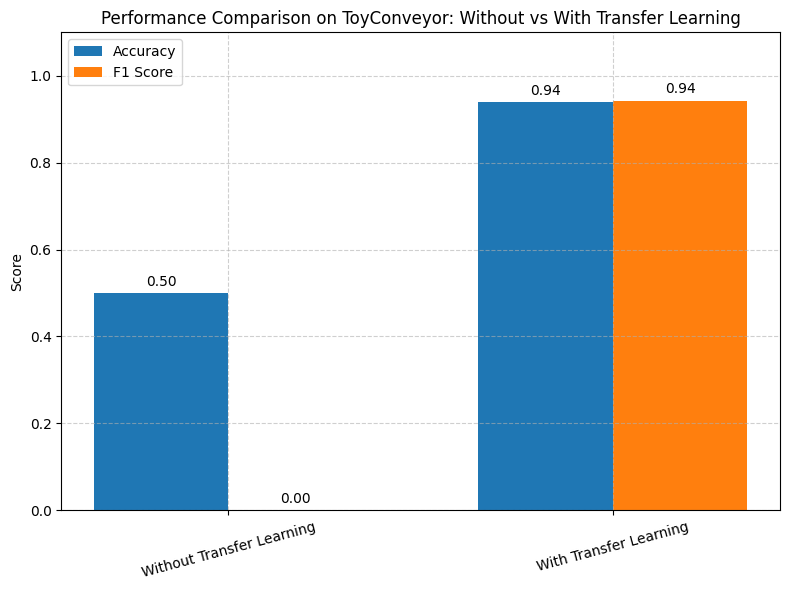

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['Without Transfer Learning', 'With Transfer Learning']
accuracy = [0.5000, 0.9394]
f1_scores = [0.0000, 0.9429]

x = np.arange(len(models))  # label locations
width = 0.35  # width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

# Labels and title
ax.set_ylabel('Score')
ax.set_title('Performance Comparison on ToyConveyor: Without vs With Transfer Learning')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=15)
ax.legend()

# Add numbers above bars
for bar in bars1 + bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.ylim(0, 1.1)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()
